In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from causalinference import CausalModel

In [2]:

df_ny=pd.read_csv("NY_Flight_covid.csv")
df_tx=pd.read_csv("TX_Flight_Covid.csv")
df_ny["treatment"]=1
df_tx["treatment"]=0
df=pd.concat([df_ny,df_tx])
df.dropna(subset=['CARRIER_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY'],inplace=True)
df

D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,YEAR,MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_CITY_NAME,DEST_CITY_NAME,...,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Test Date,New Positives,treatment,Date,New Cases
11,249153,249153,368536,2019,6,6,2019-06-01,UA,"Chicago, IL","New York, NY",...,0.0,NaN,21.0,0.0,0.0,NaN,0.0,1,NaN,NaN
13,249156,249156,368539,2019,6,6,2019-06-01,UA,"Chicago, IL","Syracuse, NY",...,0.0,NaN,0.0,0.0,53.0,NaN,0.0,1,NaN,NaN
16,249159,249159,368542,2019,6,6,2019-06-01,UA,"Rochester, NY","Chicago, IL",...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,1,NaN,NaN
17,249160,249160,368543,2019,6,6,2019-06-01,UA,"Chicago, IL","New York, NY",...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,1,NaN,NaN
21,249154,249154,368537,2019,6,6,2019-06-01,UA,"Chicago, IL","Rochester, NY",...,0.0,NaN,0.0,0.0,39.0,NaN,0.0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483105,1483105,1483105,41517,2020,5,7,2020-05-24,F9,"Austin, TX","Las Vegas, NV",...,0.0,NaN,0.0,0.0,48.0,NaN,NaN,0,2020-05-24,614.0
1483107,1483107,1483107,41519,2020,5,7,2020-05-24,F9,"Houston, TX","Denver, CO",...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0,2020-05-24,614.0
1483186,1483186,1483186,41598,2020,5,5,2020-05-22,G4,"Austin, TX","Indianapolis, IN",...,0.0,NaN,27.0,0.0,8.0,NaN,NaN,0,2020-05-22,817.0
1483189,1483189,1483189,41601,2020,5,5,2020-05-22,G4,"Austin, TX","Knoxville, TN",...,0.0,NaN,16.0,0.0,0.0,NaN,NaN,0,2020-05-22,817.0


In [3]:
df.loc[df["LATE_AIRCRAFT_DELAY"]>=1,'if_DELAY']=1
df.loc[df["LATE_AIRCRAFT_DELAY"]<1,'if_DELAY']=0

In [4]:
df['if_DELAY']

11         0.0
13         1.0
16         0.0
17         0.0
21         1.0
          ... 
1483105    1.0
1483107    0.0
1483186    1.0
1483189    0.0
1483196    1.0
Name: if_DELAY, Length: 352742, dtype: float64

In [5]:
df = df.filter(['treatment', 'ARR_DELAY_NEW', 'CARRIER_DELAY', 'SECURITY_DELAY','if_DELAY'])\
       .dropna().reset_index(drop=True)
df

,treatment,ARR_DELAY_NEW,CARRIER_DELAY,SECURITY_DELAY,if_DELAY
0,1,107.0,21.0,0.0,0.0
1,1,66.0,0.0,0.0,1.0
2,1,206.0,0.0,0.0,0.0
3,1,25.0,0.0,0.0,0.0
4,1,79.0,0.0,0.0,1.0
...,...,...,...,...,...
352737,0,50.0,0.0,0.0,1.0
352738,0,199.0,0.0,0.0,0.0
352739,0,35.0,27.0,0.0,1.0
352740,0,16.0,16.0,0.0,0.0


In [6]:
TREATMENT = 'treatment'
OUTCOME = 'if_DELAY'
df.groupby(TREATMENT)[OUTCOME].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,229450.0,0.476091,0.499429,0.0,0.0,0.0,1.0,1.0
1,123292.0,0.481897,0.499674,0.0,0.0,0.0,1.0,1.0


In [7]:
t = df[TREATMENT]
X = pd.get_dummies(df.drop(columns=[OUTCOME, TREATMENT]))
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', LogisticRegression())
])
pipe.fit(X, t)
# Predict
threshold = 0.5
df['proba'] = pipe.predict_proba(X)[:,1]
df['logit'] = df['proba'].apply(lambda p: np.log(p/(1-p)))
df['pred'] = np.where(df['proba']>=threshold, 1, 0)
df

,treatment,ARR_DELAY_NEW,CARRIER_DELAY,SECURITY_DELAY,if_DELAY,proba,logit,pred
0,1,107.0,21.0,0.0,0.0,0.370903,-0.528344,0
1,1,66.0,0.0,0.0,1.0,0.358587,-0.581504,0
2,1,206.0,0.0,0.0,0.0,0.440699,-0.238326,0
3,1,25.0,0.0,0.0,0.0,0.335814,-0.682006,0
4,1,79.0,0.0,0.0,1.0,0.365949,-0.549637,0
...,...,...,...,...,...,...,...,...
352737,0,50.0,0.0,0.0,1.0,0.349617,-0.620724,0
352738,0,199.0,0.0,0.0,0.0,0.436474,-0.255485,0
352739,0,35.0,27.0,0.0,1.0,0.327754,-0.718361,0
352740,0,16.0,16.0,0.0,0.0,0.322974,-0.740137,0


In [8]:
predictions = pipe.predict_proba(X)
predictions_binary = pipe.predict(X)

In [9]:
predictions_logit =df['logit']

In [10]:
print(f"Accuracy: {np.mean(df[TREATMENT]==df['pred']):.4f},\
 ROC AUC: {roc_auc_score(df[TREATMENT], df['proba']):.4f},\
 F1-score: {f1_score(df[TREATMENT], df['pred']):.4f}")
# Visualise confusion matrix
pd.crosstab(df[TREATMENT], df['pred']).rename(columns={0: False, 
                                                       1:True})

Accuracy: 0.6494, ROC AUC: 0.5718, F1-score: 0.0245


pred,False,True
treatment,,
0,227527,1923
1,121740,1552


some idea from : https://towardsdatascience.com/propensity-score-matching-a0d373863eec

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

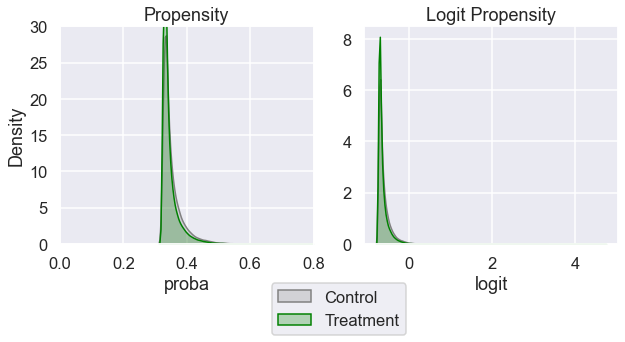

In [12]:
C_COLOUR = 'grey'
T_COLOUR = 'green'
C_LABEL = 'Control'
T_LABEL = 'Treatment'
fig, ax = plt.subplots(1,2, figsize=(10,4))
# Visualise propensity
sns.kdeplot(data=df[df[TREATMENT]==1], x='proba', shade=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[0]).\
    set(xlim=(0, 0.8), ylim=(0, 30))
sns.kdeplot(data=df[df[TREATMENT]==0], x='proba', shade=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[0]).\
    set(xlim=(0, 0.8), ylim=(0, 30))
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
# Visualise logit propensity
sns.kdeplot(data=df[df[TREATMENT]==1], x='logit', shade=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[1])
sns.kdeplot(data=df[df[TREATMENT]==0], x='logit', shade=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[1])
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("");

In [13]:
from sklearn.neighbors import NearestNeighbors

In [14]:
caliper = np.std(df.logit) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df[['logit']])


Caliper (radius) is: 0.0425



NearestNeighbors(n_neighbors=10, radius=0.042547369787875884)

In [15]:
distances , indexes = knn.kneighbors(
    df[['logit']], \
    n_neighbors=10)

In [16]:
print('For item 0, the 4 closest distances are (first item is self):')
for ds in distances[0,0:4]:
    print('Element distance: {:4f}'.format(ds))
print('...')

For item 0, the 4 closest distances are (first item is self):
Element distance: 0.000000
Element distance: 0.000000
Element distance: 0.000000
Element distance: 0.000040
...


In [17]:
print('For item 0, the 4 closest indexes are (first item is self):')
for idx in indexes[0,0:4]:
    print('Element index: {}'.format(idx))
print('...')

For item 0, the 4 closest indexes are (first item is self):
Element index: 12179
Element index: 0
Element index: 12236
Element index: 43986
...


In [18]:
def perfom_matching_v2(row, indexes, df_data):
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    prop_score_logit = row['logit']
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row.treatment == 1) and (df_data.loc[idx].treatment == 0):
            return int(idx)
         
df['matched_element'] = df.reset_index().apply(perfom_matching_v2, axis = 1, args = (indexes, df))

In [19]:
treated_with_match = ~df.matched_element.isna()
treated_matched_data = df[treated_with_match][df.columns]
treated_matched_data

,treatment,ARR_DELAY_NEW,CARRIER_DELAY,SECURITY_DELAY,if_DELAY,proba,logit,pred,matched_element
0,1,107.0,21.0,0.0,0.0,0.370903,-0.528344,0,155863.0
1,1,66.0,0.0,0.0,1.0,0.358587,-0.581504,0,177992.0
2,1,206.0,0.0,0.0,0.0,0.440699,-0.238326,0,205797.0
3,1,25.0,0.0,0.0,0.0,0.335814,-0.682006,0,277970.0
4,1,79.0,0.0,0.0,1.0,0.365949,-0.549637,0,237899.0
...,...,...,...,...,...,...,...,...,...
123287,1,117.0,117.0,0.0,0.0,0.327338,-0.720250,0,243742.0
123288,1,16.0,0.0,0.0,0.0,0.330911,-0.704068,0,202571.0
123289,1,36.0,0.0,0.0,0.0,0.341854,-0.655042,0,308691.0
123290,1,42.0,42.0,0.0,0.0,0.324095,-0.735018,0,287405.0


In [20]:
def obtain_match_details(row, all_data, attribute):
    return all_data.loc[row.matched_element][attribute]

untreated_matched_data = pd.DataFrame(data = treated_matched_data.matched_element)

attributes = ['treatment', 'ARR_DELAY_NEW', 'CARRIER_DELAY', 'SECURITY_DELAY', 'if_DELAY', 'proba', 'logit',
       'pred']
for attr in attributes:
    untreated_matched_data[attr] = untreated_matched_data.apply(obtain_match_details, axis = 1, all_data = df, attribute = attr)
    
untreated_matched_data = untreated_matched_data.set_index('matched_element')
untreated_matched_data.head(3)

,treatment,ARR_DELAY_NEW,CARRIER_DELAY,SECURITY_DELAY,if_DELAY,proba,logit,pred
matched_element,,,,,,,,
155863.0,0.0,153.0,71.0,0.0,1.0,0.370913,-0.528303,0.0
177992.0,0.0,66.0,0.0,0.0,0.0,0.358587,-0.581504,0.0
205797.0,0.0,206.0,0.0,0.0,1.0,0.440699,-0.238326,0.0


In [21]:
all_mached_data = pd.concat([treated_matched_data, untreated_matched_data])

Review

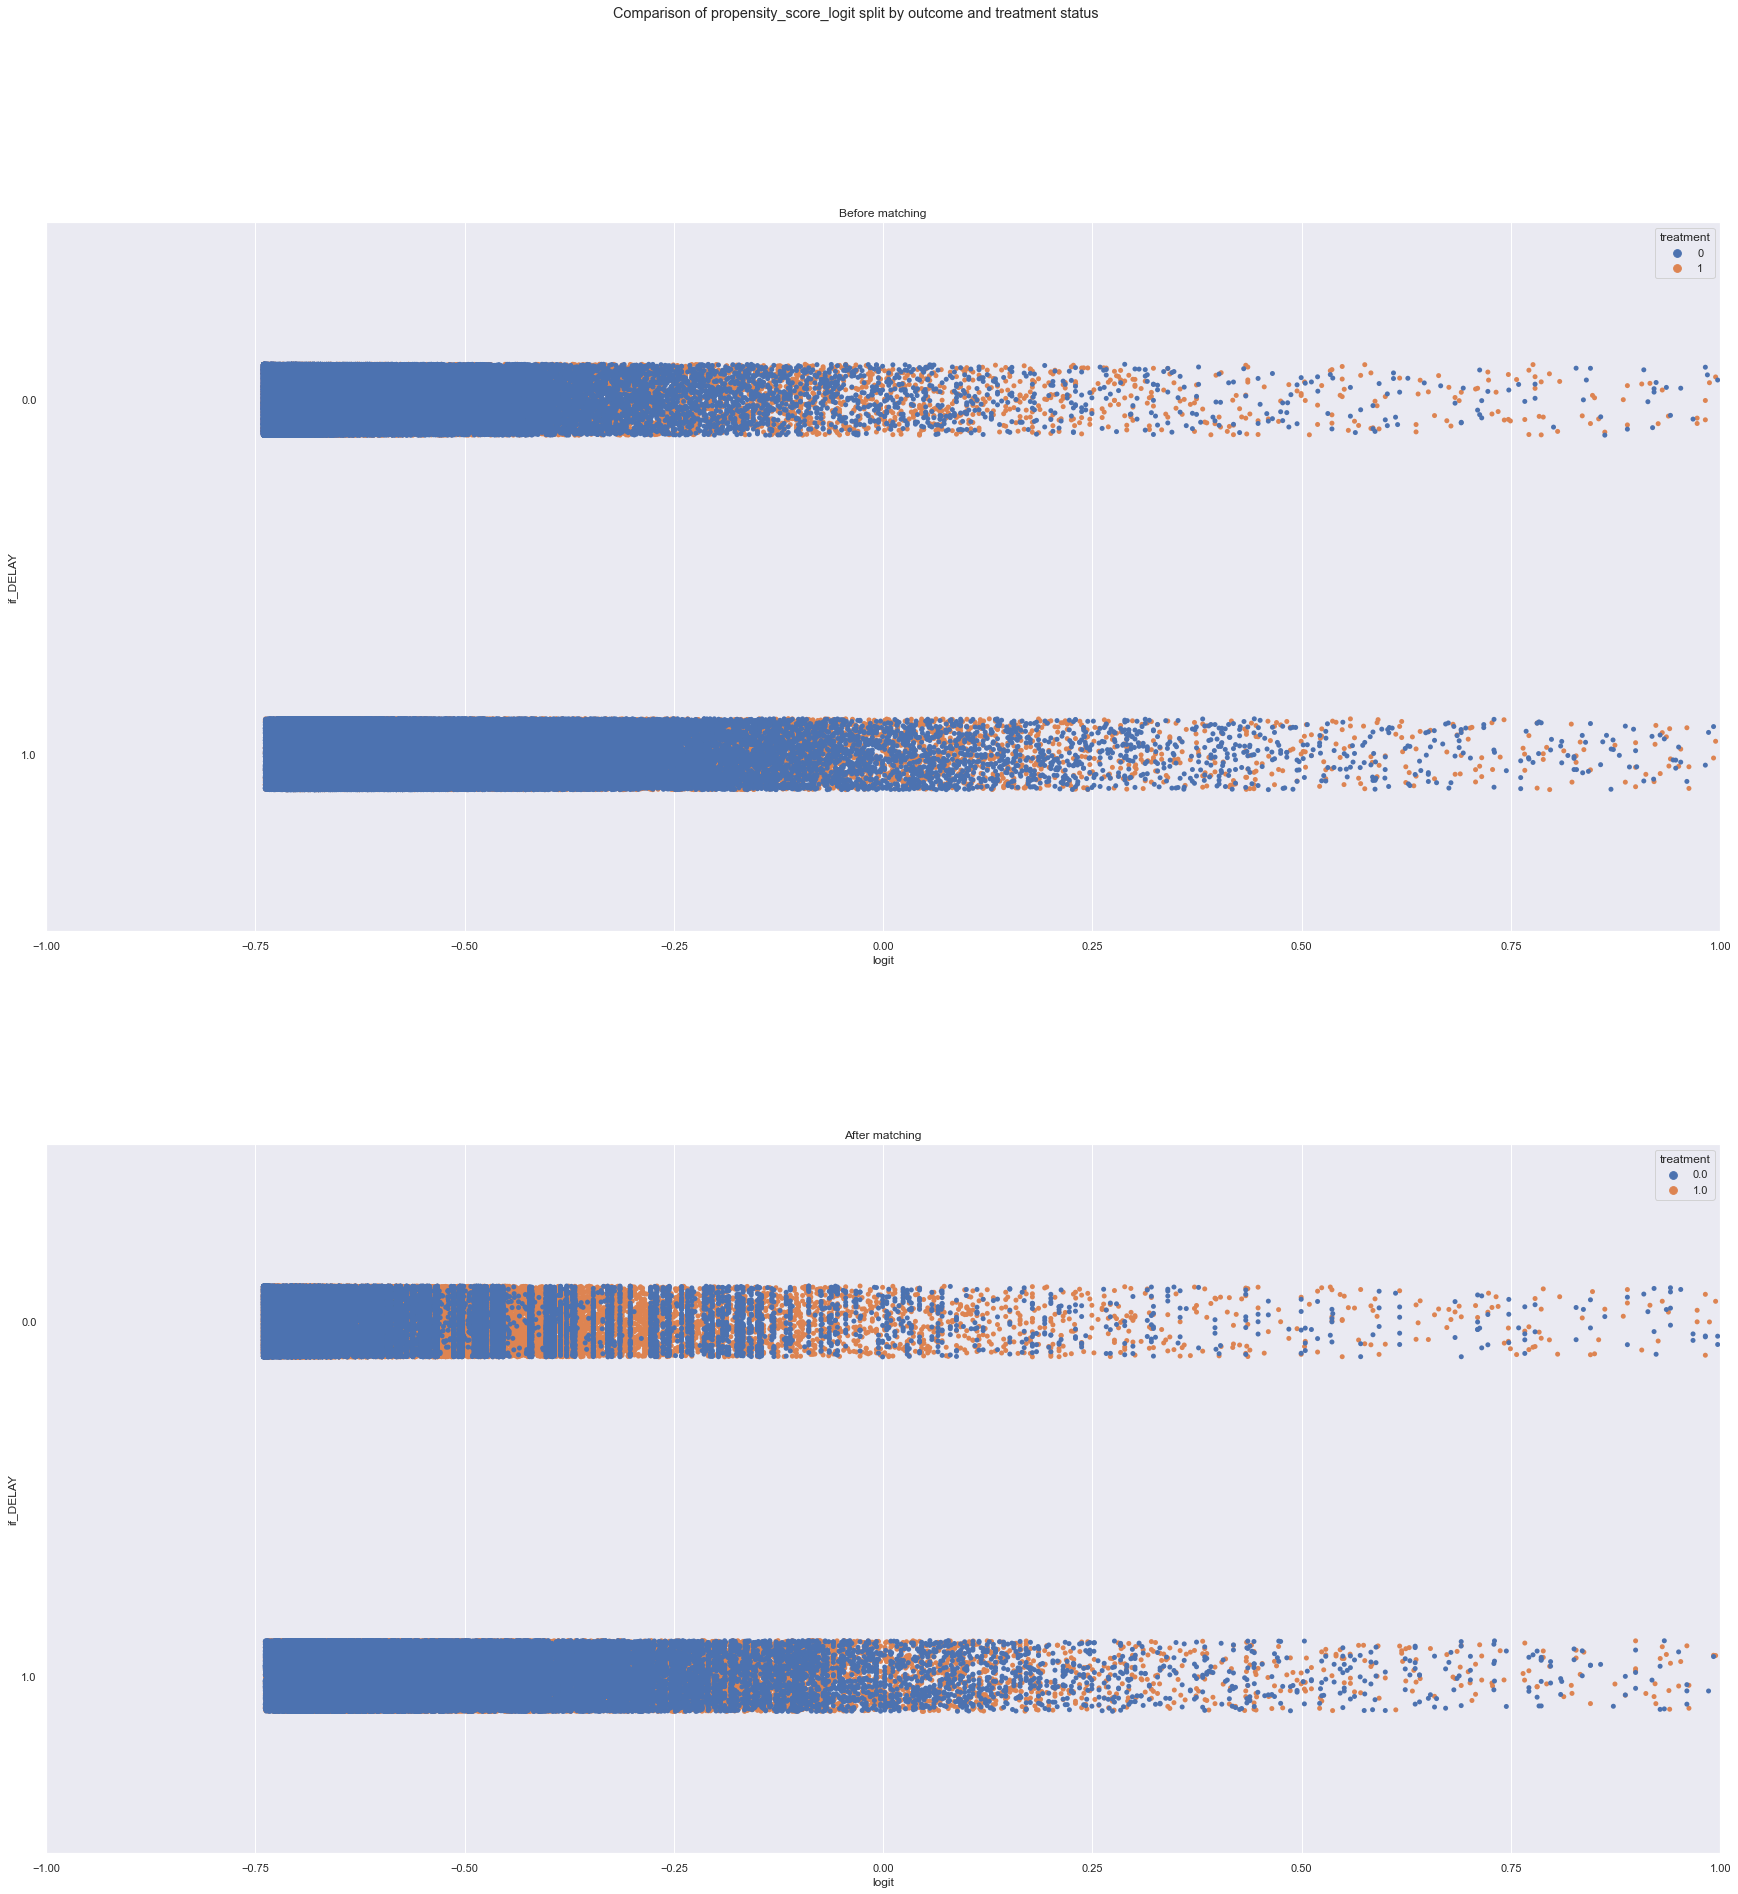

In [28]:

fig, ax = plt.subplots(2,1)
sns.set(rc={"figure.figsize":(30, 80)})

fig.suptitle('Comparison of {} split by outcome and treatment status'.format('propensity_score_logit'))
sns.stripplot(data = df, y = 'if_DELAY', x = 'logit', hue = 'treatment', orient = 'h', ax = ax[0]).set(title = 'Before matching', xlim=(-1, 1))
sns.stripplot(data = all_mached_data, y = 'if_DELAY', x = 'logit', hue = 'treatment', ax = ax[1] , orient = 'h').set(title = 'After matching', xlim=(-1, 1))
plt.subplots_adjust(hspace = 0.3)
plt.show()
fig.savefig("jitter_plot.png")


In [23]:
import matplotlib.pyplot as plt2
import seaborn as sns2

In [24]:
points_df = pd.merge(treated_matched_data[['SECURITY_DELAY','CARRIER_DELAY','matched_element']], df[['CARRIER_DELAY','SECURITY_DELAY']], how = 'right',  left_on = 'matched_element', right_index=True)

In [25]:
overview = all_mached_data[['if_DELAY','treatment']].groupby(by = ['treatment']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview)

           if_DELAY                            
               mean       var       std   count
treatment                                      
0.0        0.540802  0.248337  0.498334  123291
1.0        0.481892  0.249674  0.499674  123291


In [26]:
treated_outcome = overview['if_DELAY']['mean'][1]
treated_counterfactual_outcome = overview['if_DELAY']['mean'][0]

In [27]:
att =  treated_counterfactual_outcome-treated_outcome 
print('The Average Treatment Effect (ATT): {:.4f}'.format(att))

The Average Treatment Effect (ATT): 0.0589
